## CRM Project :
    - Author : Fkih Younès
     Jan 2018 / Paris Saclay IMSD.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import FeatureAgglomeration
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn import manifold
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn import svm
import itertools
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from imblearn.combine import SMOTETomek
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgbm
import prince
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')


#### Importing DataSets

In [2]:
dfUsers = pd.read_table('./Users.txt' , encoding='latin-1')
dfTransac = pd.read_table('./Transactions.txt' , encoding='latin-1')

#### DataSets Information & Handling Misssing Values

In [3]:
dfUsers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14840 entries, 0 to 14839
Data columns (total 13 columns):
IdUserInternal      14840 non-null int64
DateNaissance       14840 non-null object
DateInscription     14840 non-null object
NombreEnfant        14840 non-null int64
AcceptNewsletter    14840 non-null int64
AcceptPubs          14840 non-null int64
device              4386 non-null object
defaultLanguage     14840 non-null object
storeId             14840 non-null int64
src_inscr           14840 non-null int64
Email               14840 non-null object
LastLoginDate       14840 non-null object
Prenom              5601 non-null object
dtypes: int64(6), object(7)
memory usage: 1.5+ MB


In [4]:
dfTransac.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19828 entries, 0 to 19827
Data columns (total 5 columns):
IdUserInternal      19828 non-null int64
lieu                19828 non-null int64
etat                19828 non-null int64
DateTransactions    19828 non-null object
IdPrix              19828 non-null int64
dtypes: int64(4), object(1)
memory usage: 774.6+ KB


In [5]:
dfTransac['DateTransactions'] = pd.to_datetime(dfTransac['DateTransactions'])
dfUsers['DateInscription'] = pd.to_datetime(dfUsers['DateInscription'])
dfUsers['LastLoginDate'] = pd.to_datetime(dfUsers['LastLoginDate']) 
dfUsers['DateNaissance'] = dfUsers['DateNaissance'].replace(["#VALEUR!"],[np.NaN])

#### Adapting DataSet's to our BUSINESS

In [6]:
dfUsers.columns = ["idConnectedWatch","userBirthday","commandDate","NbOFConfidenceContact","isDefaultOffer","hasChronicDiseas","appUsedPlateforme","spokenLanguage","attachedMedicalCenterId","src_Inscription","Email","lastAlertDate","Name"]
dfTransac.columns = ["idConnectedWatch","isMoving","RequestFor","DateOfCheck","predictedHealthStatus"]

In [7]:
dfUsers.head()

,idConnectedWatch,userBirthday,commandDate,NbOFConfidenceContact,isDefaultOffer,hasChronicDiseas,appUsedPlateforme,spokenLanguage,attachedMedicalCenterId,src_Inscription,Email,lastAlertDate,Name
0,8205,NaN,2008-05-23,0,1,0,NaN,fr,1,1,820590092@yopmail.com,2015-04-01,NaN
1,25967,NaN,2008-11-09,0,1,0,NaN,fr-FR,1,1,25967828914@yopmail.com,2014-04-26,NaN
2,26263,NaN,2008-09-18,0,1,1,NaN,fr,1,1,26263850257@yopmail.com,2015-07-01,NaN
3,37866,NaN,2009-09-02,0,0,0,NaN,fr,1,1,37866106245@yopmail.com,2015-06-01,NaN
4,40148,NaN,2009-01-06,0,0,0,NaN,fr-FR,1,1,40148875595@yopmail.com,2014-07-02,NaN


In [8]:
dfTransac.head()

,idConnectedWatch,isMoving,RequestFor,DateOfCheck,predictedHealthStatus
0,10,7,30,2014-01-23,3
1,10,7,30,2014-02-13,3
2,10,7,30,2014-02-20,3
3,10,7,30,2014-02-28,4
4,10,7,30,2014-09-02,4


####  Droping unuseful Columns

In [9]:
dfUsers = dfUsers.drop("Name",axis=1)
dfUsers = dfUsers.drop("Email",axis=1)

###### adapting Users Dataset

In [10]:
dfUsers.spokenLanguage.replace(['fr-FR','fr-fr','fr-CA','it-IT','en-GB','en-gb','en-US'],['fr','fr','fr','it','en','en','en'], inplace=True)
dfUsers.attachedMedicalCenterId.replace([1,0,4,2],['France','England','Italy','Tunisia'], inplace=True)
dfUsers.src_Inscription.replace([1,2,0,3,4,5],['market','social media','official WebSite','mail','recommandations','advertisement'], inplace=True)
dfUsers.appUsedPlateforme.replace([np.NaN],["website"], inplace=True)

###### adapting Transactions Dataset

In [11]:
dfTransac.isMoving.replace([7],[1], inplace=True)
dfTransac.RequestFor.replace([30,20,2],["Heartbeat","Pressure","Temperature"], inplace=True)
dfTransac = pd.get_dummies(dfTransac,columns=["RequestFor"],dummy_na=False)
maxDate = dfUsers["commandDate"].max()
dfUsers["commandSince"] = dfUsers["commandDate"].apply(lambda x : (maxDate.date() - x.date()).days)

#### Vizualisation

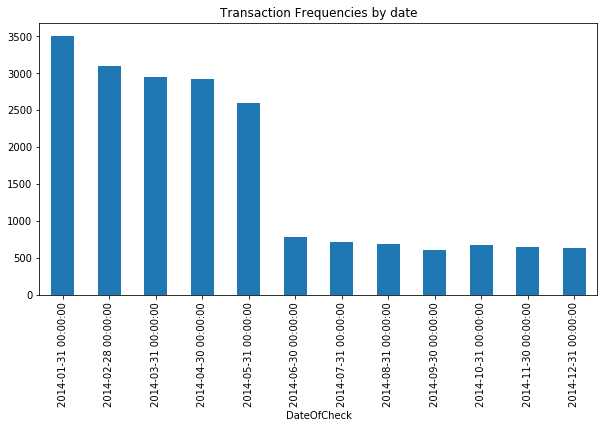

In [12]:
dfTransac.set_index('DateOfCheck').groupby([pd.TimeGrouper('M')])["idConnectedWatch"].count().plot(kind="bar",figsize=(10, 5),stacked=True)
plt.title("Transaction Frequencies by date")
plt.show()

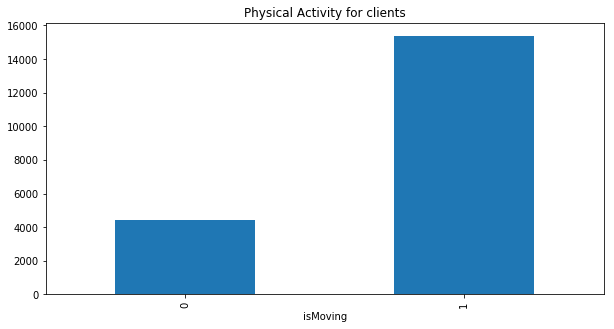

In [13]:
dfTransac.groupby(["isMoving"])["idConnectedWatch"].count().plot(kind="bar",figsize=(10, 5),stacked=True)
plt.title("Physical Activity for clients")
plt.show()

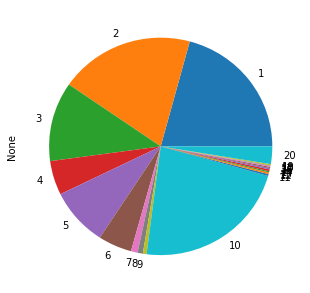

In [14]:
dfTransac.groupby(["predictedHealthStatus"]).size().plot.pie(subplots=True,figsize=(5, 5))
plt.show()

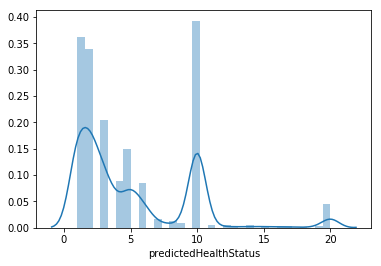

In [15]:
sns.distplot(dfTransac["predictedHealthStatus"])
plt.show()

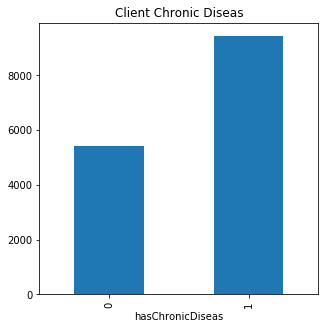

In [16]:
dfUsers.groupby("hasChronicDiseas").size().plot.bar(subplots=True,figsize=(5, 5))
plt.title("Client Chronic Diseas")
plt.show()

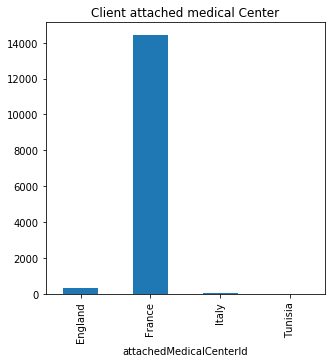

In [17]:
dfUsers.groupby("attachedMedicalCenterId").size().plot.bar(subplots=True,figsize=(5, 5))
plt.title("Client attached medical Center")
plt.show()

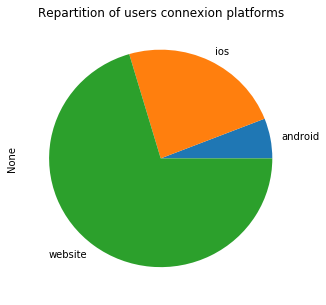

In [18]:
dfUsers.groupby(["appUsedPlateforme"]).size().plot.pie(subplots=True,figsize=(5, 5))
plt.title("Repartition of users connexion platforms")
plt.show()

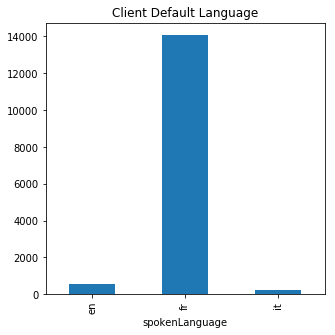

In [19]:
dfUsers.groupby("spokenLanguage").size().plot.bar(subplots=True,figsize=(5, 5))
plt.title("Client Default Language")
plt.show()

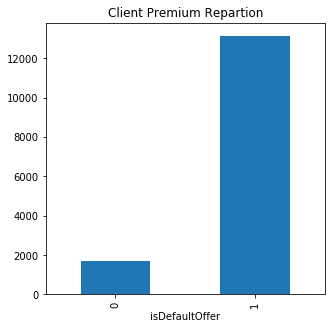

In [20]:
dfUsers.groupby("isDefaultOffer").size().plot.bar(subplots=True,figsize=(5, 5))
plt.title("Client Premium Repartion")
plt.show()

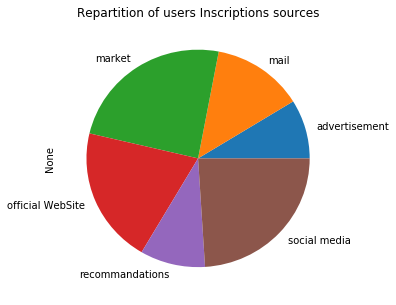

In [21]:
dfUsers.groupby(["src_Inscription"]).size().plot.pie(subplots=True,figsize=(5, 5))
plt.title("Repartition of users Inscriptions sources")
plt.show()

#### Preparing DataSet : 

In [22]:
def clientStatus(detectedHealthLevel):
    if(detectedHealthLevel>=11):
        return "isInCertainDanger"
    elif(detectedHealthLevel<11 and detectedHealthLevel>=8):
        return "mustAlertContacts"
    elif(detectedHealthLevel<8 and detectedHealthLevel>=5):
        return "toBeRechcked"
    elif(detectedHealthLevel<5):
        return "isHealthStable"


In [23]:
maxDate = dfTransac["DateOfCheck"].max()
dfTransac["elapsedDays"] = dfTransac["DateOfCheck"].apply(lambda x : (maxDate.date() - x.date()).days)
dfTransac = dfTransac.drop("DateOfCheck",axis=1)

###### Engineering new Features

In [24]:
averageHealthStatus =  dfTransac.groupby("idConnectedWatch")["predictedHealthStatus"].mean().fillna(0)
minHealthStatus =  dfTransac.groupby("idConnectedWatch")["predictedHealthStatus"].min().fillna(0).tolist()
healthStatusSum =  dfTransac.groupby("idConnectedWatch")["predictedHealthStatus"].sum().fillna(0).tolist()
maxHealthStatus =  dfTransac.groupby("idConnectedWatch")["predictedHealthStatus"].max().fillna(0).tolist()
healthStatusVar =  dfTransac.groupby("idConnectedWatch")["predictedHealthStatus"].var().fillna(0).tolist()
daysCheckMean = dfTransac.groupby('idConnectedWatch')['elapsedDays'].mean().fillna(0).tolist()
daysCheckMin = dfTransac.groupby('idConnectedWatch')['elapsedDays'].min().fillna(0).tolist()
daysCheckMax = dfTransac.groupby('idConnectedWatch')['elapsedDays'].max().fillna(0).tolist()
daysCheckVar = dfTransac.groupby('idConnectedWatch')['elapsedDays'].var().fillna(0).tolist()
sumActivity = dfTransac.groupby('idConnectedWatch')['isMoving'].sum().fillna(0).tolist()
averageActivity = dfTransac.groupby('idConnectedWatch')['isMoving'].mean().fillna(0).tolist()
heartBeatCheckSum = dfTransac.groupby('idConnectedWatch')['RequestFor_Heartbeat'].sum().fillna(0).tolist()
heartBeatCheckMean = dfTransac.groupby('idConnectedWatch')['RequestFor_Heartbeat'].mean().fillna(0).tolist()
pressureCheckSum = dfTransac.groupby('idConnectedWatch')['RequestFor_Pressure'].sum().fillna(0).tolist()
pressureCheckMean = dfTransac.groupby('idConnectedWatch')['RequestFor_Pressure'].mean().fillna(0).tolist()
temperatureCheckSum = dfTransac.groupby('idConnectedWatch')['RequestFor_Temperature'].sum().fillna(0).tolist()
temperatureCheckMean = dfTransac.groupby('idConnectedWatch')['RequestFor_Temperature'].mean().fillna(0).tolist()

In [25]:
dfEngineered = pd.DataFrame(
    {
     'idConnectedWatch':averageHealthStatus.index,
     'averageHealthStatus': averageHealthStatus,
     'minHealthDetected': minHealthStatus,
     'maxHealthDetected': maxHealthStatus,
     'varHealthDetected':healthStatusVar,
     'averageDaysCheck': daysCheckMean,
     'minDaysCheck': daysCheckMin,
     'maxDaysCheck': daysCheckMax,
     'varDaysCheck':daysCheckVar,
     'maxActivity': sumActivity,
     'meanActivity':averageActivity,
     'sumPressureCheck': pressureCheckSum,
     'meanPressureCheck':pressureCheckMean,
     'sumHeartBeatCheck': heartBeatCheckSum,
     'meanHeartBeatCheck':heartBeatCheckMean,
     'sumTemperatureCheck': temperatureCheckSum,
     'meanTemperatureCheck':temperatureCheckMean,
    },index=averageHealthStatus.index)

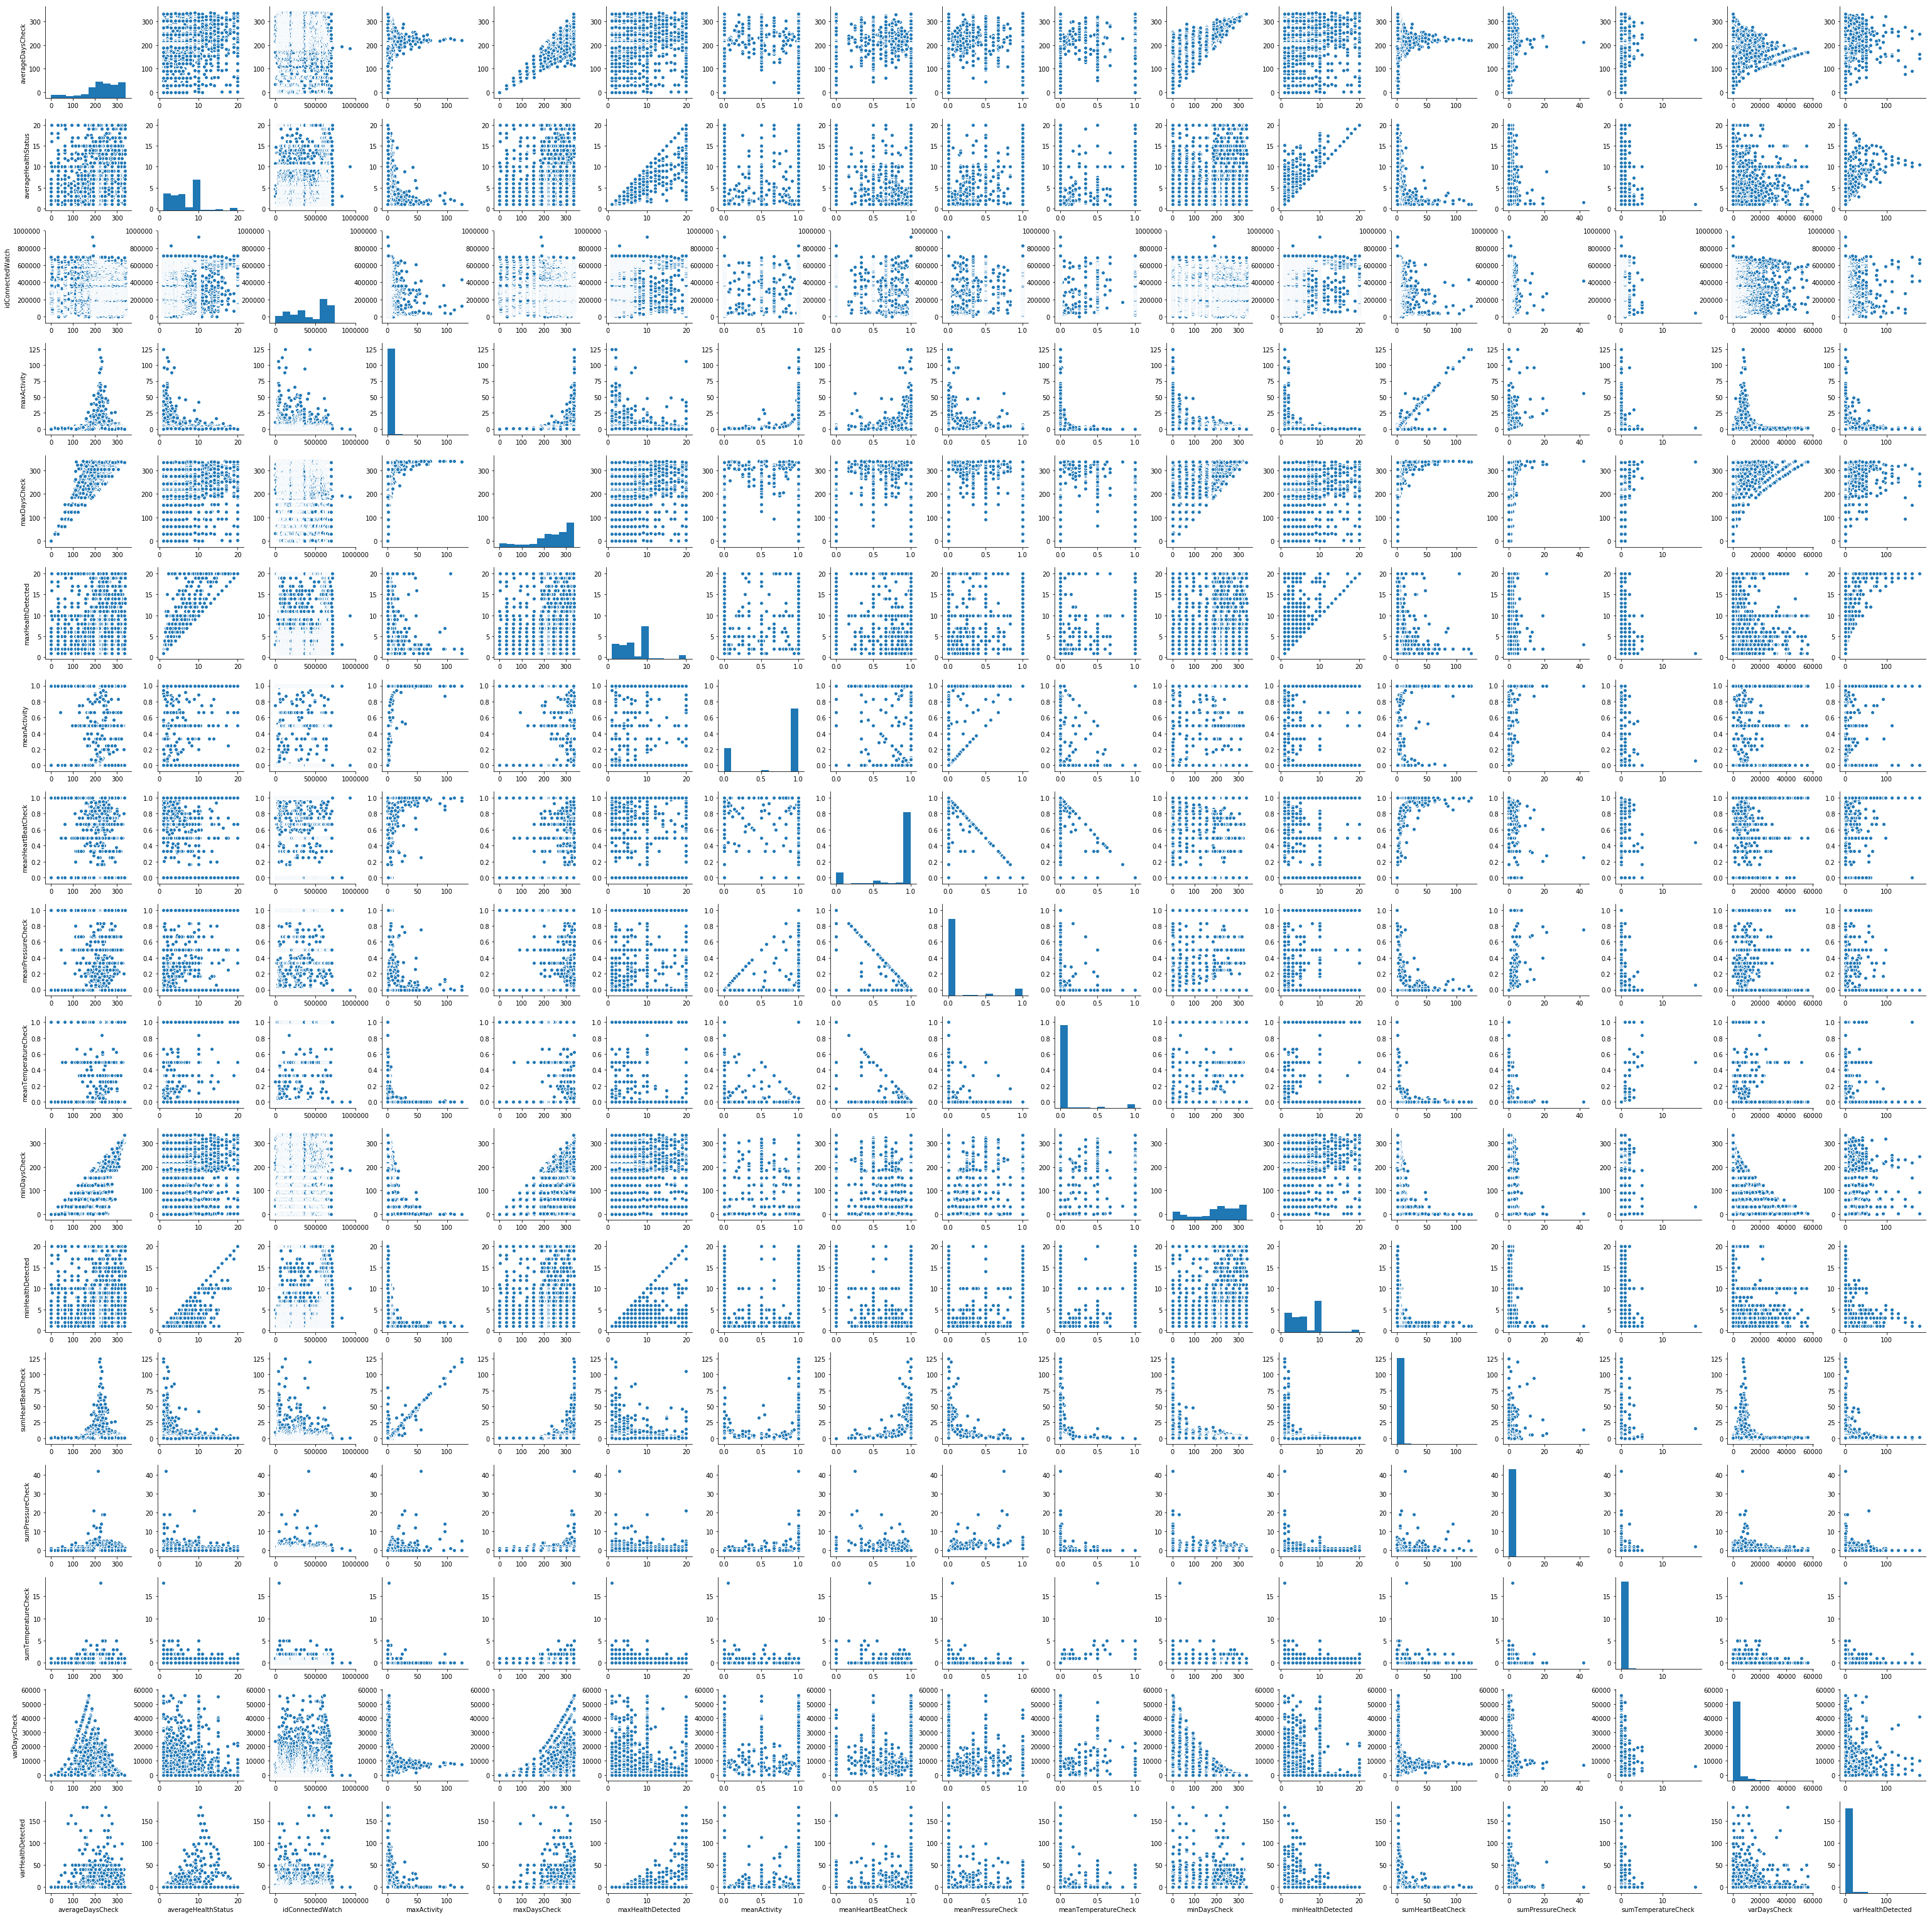

In [26]:
columns = [elt for elt in dfEngineered.columns if(elt != "idConnectedWatch")]
sns.pairplot(dfEngineered)
plt.show()

##### selecting Users useful criterea from User's DataSet done by merging technic

In [27]:
dfCRM = dfEngineered.merge(dfUsers[["idConnectedWatch","hasChronicDiseas"]],on="idConnectedWatch",how="left")
dfCRM.set_index("idConnectedWatch",inplace=True)
dfCRM.hasChronicDiseas.fillna(0)
dfCRM.head()

,averageDaysCheck,averageHealthStatus,maxActivity,maxDaysCheck,maxHealthDetected,meanActivity,meanHeartBeatCheck,meanPressureCheck,meanTemperatureCheck,minDaysCheck,minHealthDetected,sumHeartBeatCheck,sumPressureCheck,sumTemperatureCheck,varDaysCheck,varHealthDetected,hasChronicDiseas
idConnectedWatch,,,,,,,,,,,,,,,,,
10,214.4,4.60,10,316,10,1.00,1.00,0.0,0.00,61,3,10,0,0,7365.600000,4.488889,0.0
12,169.5,5.50,2,278,6,1.00,1.00,0.0,0.00,61,5,2,0,0,23544.500000,0.500000,1.0
17,246.5,10.75,3,310,20,0.75,0.75,0.0,0.25,192,3,3,0,1,2540.333333,48.916667,0.0
318,279.0,3.00,1,279,3,1.00,1.00,0.0,0.00,279,3,1,0,0,0.000000,0.000000,0.0
558,218.0,10.00,0,218,10,0.00,1.00,0.0,0.00,218,10,1,0,0,0.000000,0.000000,0.0


In [28]:
dfCRM.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9540 entries, 10 to 928740
Data columns (total 17 columns):
averageDaysCheck        9540 non-null float64
averageHealthStatus     9540 non-null float64
maxActivity             9540 non-null int64
maxDaysCheck            9540 non-null int64
maxHealthDetected       9540 non-null int64
meanActivity            9540 non-null float64
meanHeartBeatCheck      9540 non-null float64
meanPressureCheck       9540 non-null float64
meanTemperatureCheck    9540 non-null float64
minDaysCheck            9540 non-null int64
minHealthDetected       9540 non-null int64
sumHeartBeatCheck       9540 non-null int64
sumPressureCheck        9540 non-null int64
sumTemperatureCheck     9540 non-null int64
varDaysCheck            9540 non-null float64
varHealthDetected       9540 non-null float64
hasChronicDiseas        9537 non-null float64
dtypes: float64(9), int64(8)
memory usage: 1.3 MB


##### Deleting missing 3 rows  /  9550 rows ;))

In [29]:
dfCRM.dropna(inplace=True)

##### Let's check some univariate statistics 

In [30]:
dfCRM.describe()

,averageDaysCheck,averageHealthStatus,maxActivity,maxDaysCheck,maxHealthDetected,meanActivity,meanHeartBeatCheck,meanPressureCheck,meanTemperatureCheck,minDaysCheck,minHealthDetected,sumHeartBeatCheck,sumPressureCheck,sumTemperatureCheck,varDaysCheck,varHealthDetected,hasChronicDiseas
count,9537.000000,9537.000000,9537.000000,9537.000000,9537.000000,9537.000000,9537.000000,9537.000000,9537.000000,9537.000000,9537.000000,9537.00000,9537.000000,9537.000000,9537.000000,9537.000000,9537.000000
mean,226.435890,6.686381,1.614030,240.629024,7.062284,0.726494,0.849915,0.101351,0.048734,207.540841,6.389535,1.81598,0.191360,0.071406,1702.423616,1.866968,0.453182
std,79.746981,4.286851,4.964664,83.020173,4.548570,0.440422,0.337757,0.284439,0.206214,95.529629,4.325788,5.01836,0.816139,0.354497,5471.971742,9.900859,0.497829
min,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,191.000000,3.000000,0.000000,201.000000,3.000000,0.000000,1.000000,0.000000,0.000000,155.000000,3.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,238.062500,6.000000,1.000000,259.000000,6.000000,1.000000,1.000000,0.000000,0.000000,227.000000,5.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,286.000000,10.000000,1.000000,307.000000,10.000000,1.000000,1.000000,0.000000,0.000000,284.000000,10.000000,1.00000,0.000000,0.000000,0.000000,0.000000,1.000000
max,338.000000,20.000000,125.000000,338.000000,20.000000,1.000000,1.000000,1.000000,1.000000,338.000000,20.000000,125.00000,42.000000,18.000000,56112.500000,180.500000,1.000000


###### Let's check some bivariate statistics 

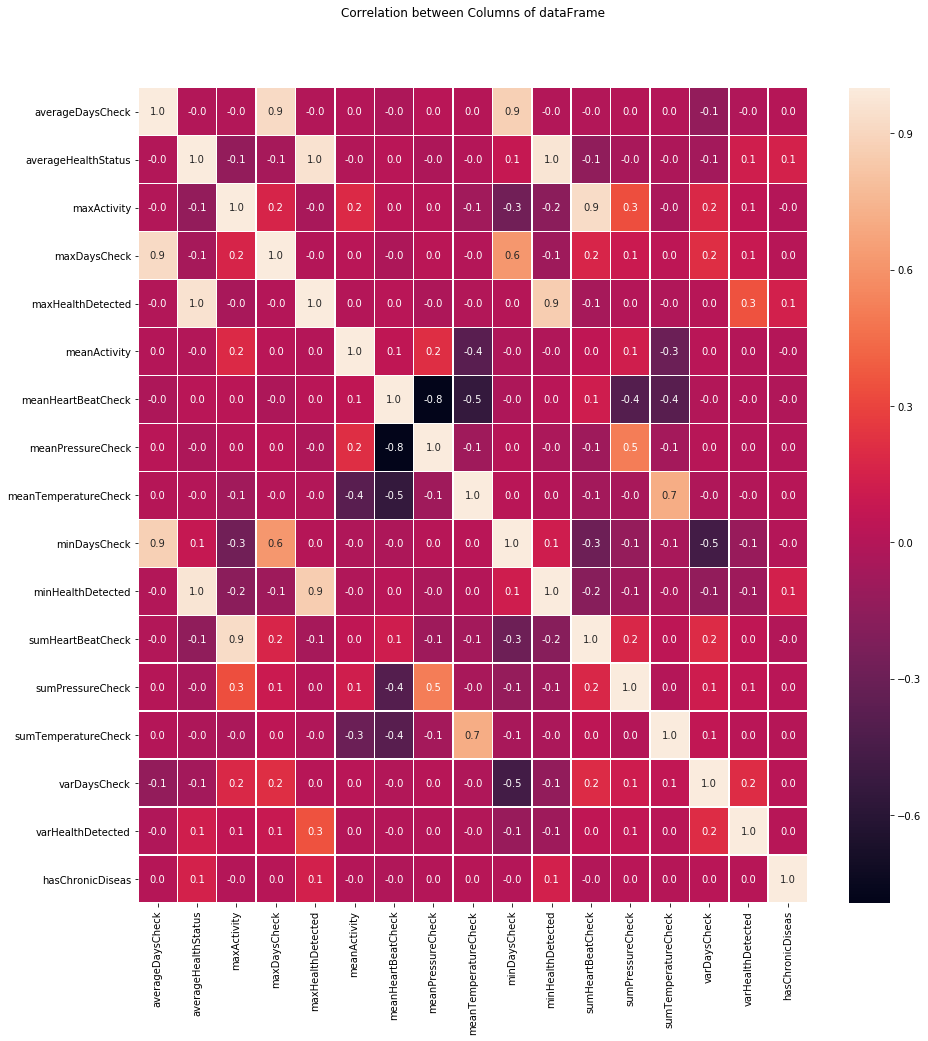

In [31]:
Correlation = dfCRM.corr() # We get the correlation matrix
#Plotting other Correlations
f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(Correlation, annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.title("Correlation between Columns of dataFrame",y=1.08)
plt.show()


In [32]:
dfCRM = dfCRM.drop("sumPressureCheck",axis=1)
dfCRM = dfCRM.drop("averageDaysCheck",axis=1)
dfCRM = dfCRM.drop("maxDaysCheck",axis=1)
dfCRM = dfCRM.drop("maxHealthDetected",axis=1)
dfCRM = dfCRM.drop("minHealthDetected",axis=1)
dfCRM = dfCRM.drop("sumTemperatureCheck",axis=1)
dfCRM = dfCRM.drop("sumHeartBeatCheck",axis=1)

###### Let's try corelation circle to undertand our Features

In [33]:
colums = [elt for elt in dfCRM.columns if elt not in ["Cluster","PCA2","PCA1"]]

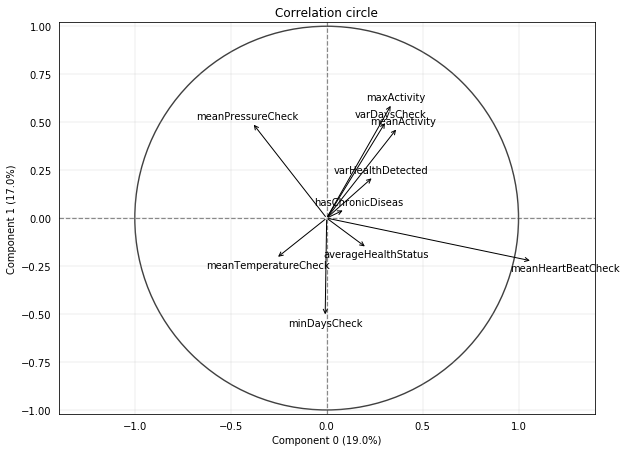

In [34]:
tmpdf = dfCRM[colums].copy()
pca = prince.PCA(tmpdf, n_components=2)
pca.plot_correlation_circle()
plt.show()

###### PCA : Dimensionality reduction

In [35]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(dfCRM)

In [36]:
pca.explained_variance_ratio_

array([  9.99759368e-01,   2.36101409e-04])

In [37]:
dfCRM["PCA1"]= pca_data[:,0]
dfCRM["PCA2"]= pca_data[:,1]

### Non Supervised Learning

######  1 - CAH  afin de regrouper nos Clients

In [38]:
Z = linkage(dfCRM,method='ward',metric='euclidean')

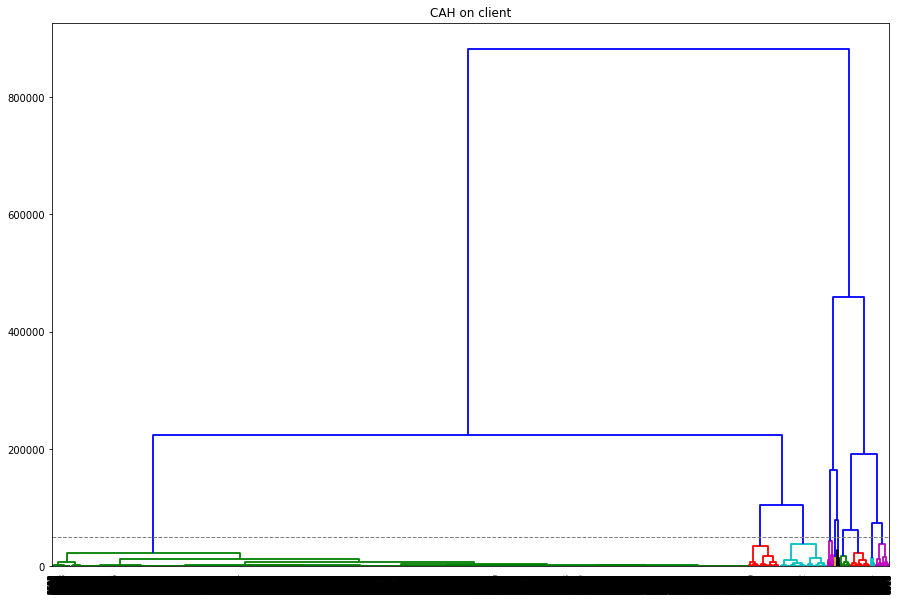

In [39]:
from scipy.cluster import hierarchy
plt.figure(figsize=(15,10))
hierarchy.dendrogram(Z, leaf_rotation=90, leaf_font_size=8,color_threshold=50000)
plt.title("CAH on client")
plt.axhline(y=50000, c='grey', lw=1, linestyle='dashed')
plt.show()

In [40]:
dfCRM["Cluster"]=fcluster(Z,t=50000,criterion='distance')
dfCRM["Cluster"].max()

10

######  Regardant nos individus avec ce nouveau partionnement 

######  PCA 2D Projection :  

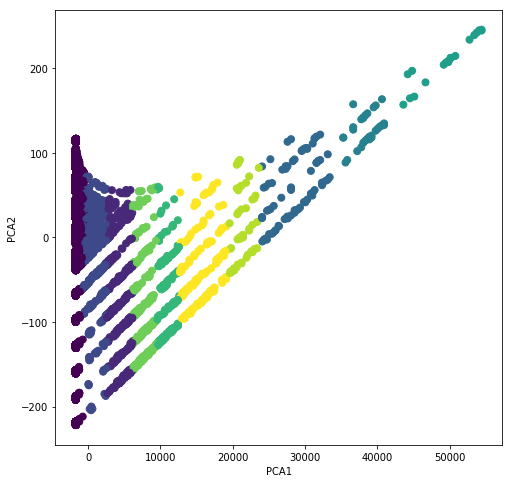

In [41]:
plt.figure(figsize=(8,8))
plt.scatter(dfCRM["PCA1"], dfCRM["PCA2"],c=dfCRM["Cluster"])
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()

######  Les Clusters ! :

In [42]:
d = {'col1': dfCRM["Cluster"], 'col2': dfCRM.index }
df = pd.DataFrame(data=d)

(df.groupby('col1')).head()
pd.crosstab(columns=df['col2'] ,index = df["col1"])

col2,10,12,17,318,558,734,749,1398,1465,1902,...,709689,709716,709753,709811,709828,710015,710029,710169,824172,928740
col1,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
print("average Health Status Mean"+str(dfCRM['averageHealthStatus'].mean()))

average Health Status Mean6.686380767633532


In [44]:
# create a unique identifier variable from the index for the
# cluster training data to merge with the cluster assignment variable
clus_train=dfCRM.copy()
clus_train.reset_index(level=0, inplace=True)
# create a list that has the new index variable
cluslist=list(clus_train.index)
# create a list of cluster assignments
labels=list(clus_train['Cluster'] )
# combine index variable list with cluster assignment list into a dictionary
newlist=dict(zip(cluslist, labels))
newlist
# convert newlist dictionary to a dataframe
newclus=pd.DataFrame.from_dict(newlist, orient='index')
newclus
# rename the cluster assignment column
newclus.columns = ['cluster']
# merge the cluster assignment dataframe with the cluster training variable dataframe
# by the index variable
merged_train=pd.merge(clus_train, newclus, left_index=True,right_index=True)
merged_train.head(n=100)

# cluster frequencies
merged_train.cluster.value_counts()

# FINALLY calculate clustering variable means by cluster
clustergrp = merged_train.groupby('cluster').mean()
## Add the mean value of each column 
ColumnMeanValue=clus_train.mean()
clustergrp.loc["ColumnMeanValue"]=ColumnMeanValue
# drop some useless colunms
clustergrp=clustergrp.drop(['idConnectedWatch','PCA1','PCA2','Cluster'], axis=1)
print ("Clustering variablemerged_train means by cluster")
clustergrp

Clustering variablemerged_train means by cluster


,averageHealthStatus,maxActivity,meanActivity,meanHeartBeatCheck,meanPressureCheck,meanTemperatureCheck,minDaysCheck,varDaysCheck,varHealthDetected,hasChronicDiseas
cluster,,,,,,,,,,
1,6.888155,0.806456,0.717672,0.849355,0.098939,0.051705,227.805195,29.484702,0.638291,0.448998
2,5.219069,9.980556,0.812658,0.865499,0.105103,0.029398,102.077778,6099.863191,8.194705,0.488889
3,6.256411,3.155393,0.767664,0.855023,0.113469,0.031507,188.998172,2525.739262,7.678902,0.453382
4,6.610417,1.650000,0.756250,0.847917,0.114583,0.037500,30.337500,30007.687500,8.364583,0.475000
5,6.510753,1.612903,0.790323,0.790323,0.161290,0.048387,16.483871,40163.629032,13.478495,0.580645
6,6.071429,1.619048,0.809524,0.857143,0.119048,0.023810,5.904762,51274.738095,6.738095,0.476190
7,5.010048,3.869231,0.775934,0.866429,0.103449,0.030122,52.592308,12700.431230,9.615873,0.438462
8,4.720934,10.729258,0.733911,0.858338,0.106769,0.034893,57.519651,9277.114552,7.030262,0.502183
9,6.470760,1.666667,0.644737,0.802632,0.152047,0.045322,42.894737,23003.873977,4.913450,0.578947


###### Interpretation

-cluster 1 :(Mean Activity, meanHeartBeatCheck,meanPressureCheck,meanTemperatureCheck, hasChronicDiseas ) 
Le 1er cluster représente ceux qui ont une activité normale mais qui souffrent d'une maladie chronique,
ils ont tendance à contrôler leur pression , température, et leur coeur.

-cluster 2 est caractérisé par sa  meanPressureCheck c'est  à dire la vérification de la pression moyenne
dans le but d’évaluation de leur hémodynamique => Diagnostic et surveillance

-cluster 3 : est caractérisé par sa meanHeartBeatCheck : ces personnes vérifient réguliérement leur battement de coeur
( par crainte d'une maladie hériditaire lié au coeur peut-être)

-cluster 4 réprensente les personnes qui souffrent d'une maladie chhronique et vérifient réguliérement leur battement de coeur

-cluster 5 :(maxActivity, meanTemperatureCheck) caractérise les personnes qui sont actives et qui vérifient leur temprérature de façon régulière ce qui est tout à fait normal.

-cluster 6 :( hasChronicDiseas  ,maxActivity ,meanHeartBeatCheck  meanPressureCheck) : les personnes souffrant d'une maladie
chronique et exércent des activités, ils ont tendances à mesurer réguliéreement leur préssion et battement de coeur.

-cluster 7 : les personnes qui ont une maladie chronique et surveillent réguliérement leur santé (pression, temprérature et coeur)

-cluster 8 : représente les personnes qui ont une maladie chronique et qui font une activité normale et qui surveillent quand même réguliérement leur santé (pression, temprérature et coeur)

-cluster 9 : les personnes qui ont une maladie chronique et qui sont en même temps hyperactifs, ces gens là surveillent réguliérement leur santé (pression, temprérature et coeur) 

-cluster 10 réprensente les personnes qui souffrent d'une maladie chronique et vérifient réguliérement leur température
 

###### T-distributed  stochastic neighbor embedding  2D Projection : 

In [45]:
tsne = manifold.TSNE(n_components= 2)
trans_data_tsne = tsne.fit_transform(dfCRM[colums])

In [46]:
dfCRM["TSNE1"]=trans_data_tsne[:,0]
dfCRM["TSNE2"]=trans_data_tsne[:,1]

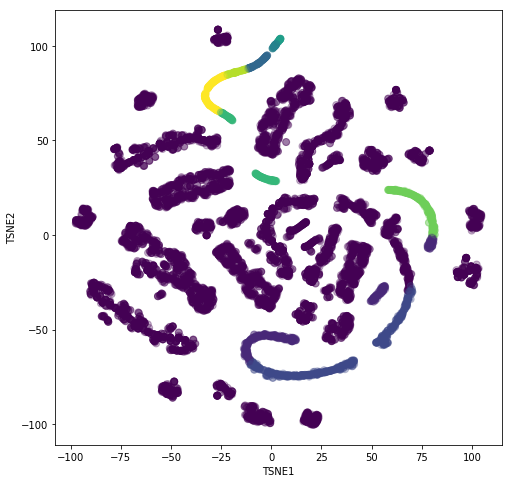

In [47]:
plt.figure(figsize=(8,8))
plt.scatter(dfCRM["TSNE1"], dfCRM["TSNE2"],c=dfCRM["Cluster"],alpha=0.3)
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.show()

###### 2- K-Means Clustering :

In [48]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(dfCRM[colums])
dfCRM["kmeans"] = kmeans.labels_

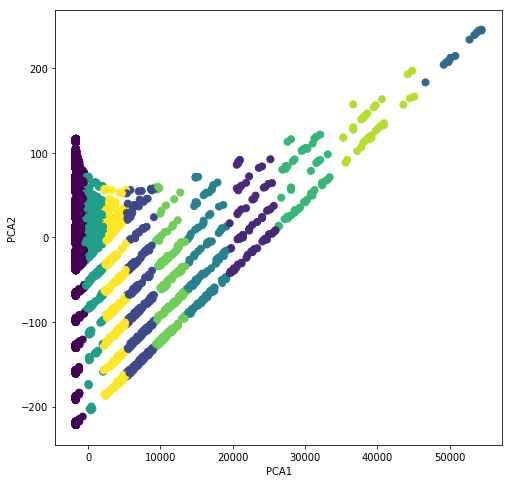

In [49]:
plt.figure(figsize=(8,8))
plt.scatter(dfCRM["PCA1"], dfCRM["PCA2"],c=dfCRM["kmeans"])
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()
plt.figure(figsize=(5,5))

#### Supervised Learning

In [50]:
dfSL = pd.get_dummies(dfUsers,columns=["appUsedPlateforme","spokenLanguage","attachedMedicalCenterId","src_Inscription"],dummy_na=False) 
dfSL["hasBirthday"] = dfSL["userBirthday"].apply(lambda x : 1 if(x != np.nan) else 0)
dfSL = dfSL.drop("userBirthday",axis=1)
dfSL = dfSL.drop("commandDate",axis=1)
dfSL = dfSL.drop("lastAlertDate",axis=1)
dfSL = dfSL.drop("commandSince",axis=1)
dfSL.set_index("idConnectedWatch",inplace=True)

In [51]:
SLColumns = [elt for elt in dfSL.columns if(elt != "isDefaultOffer")]
target = dfSL[["isDefaultOffer"]]
X = dfSL[SLColumns]
X_train, X_testInit, y_train, y_testInit = train_test_split(X,target, test_size=0.33, random_state=69,stratify=target,shuffle=True)

###### Class Premium Statistics

In [52]:
len(target[target["isDefaultOffer"]==0])/len(target)

0.11401617250673854

In [53]:
sm = SMOTETomek()
X_resampled, y_resampled = sm.fit_sample(X, target)

In [54]:
XEng = pd.DataFrame(X_resampled)
targetEng = pd.DataFrame(y_resampled,columns=["target"])
print(str(round((float(targetEng[targetEng["target"]==0].shape[0])/ targetEng.shape[0])*100,2))+" % Of record with 0 as class")
print(str(round((float(targetEng[targetEng["target"]==1].shape[0])/targetEng.shape[0])*100,2))+" % Of record with 1 as class")

50.0 % Of record with 0 as class
50.0 % Of record with 1 as class


In [55]:
X_train, X_test, y_train, y_test = train_test_split(XEng,targetEng, test_size=0.33, random_state=69,stratify=targetEng,shuffle=True)

###### Confusion Matrix Plot Function

In [56]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.rcParams["figure.figsize"] = (5,5)

    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


###### Random ForestClassifier

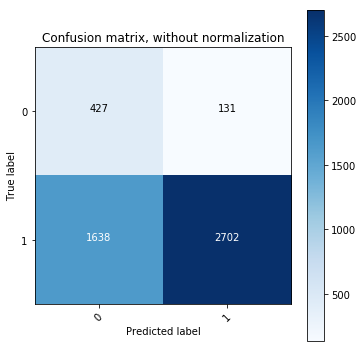

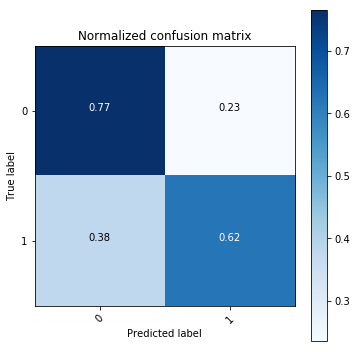

In [75]:
clf1 = RandomForestClassifier(random_state=0)
clf1.fit(X_train, y_train)
predictionEng = clf1.predict(X_testInit)
# Compute confusion matrix
class_names = [0,1]
cnf_matrix = confusion_matrix(y_testInit, predictionEng)
np.set_printoptions(precision=3)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()


###### AdaBoostClassifier

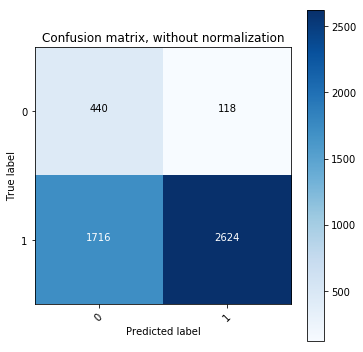

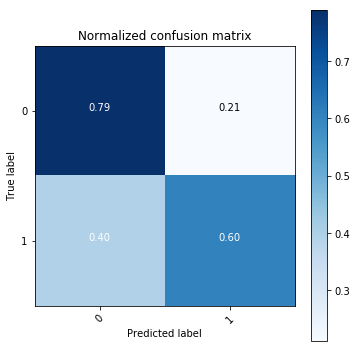

In [77]:
rng = np.random.RandomState(1)
adaClf = AdaBoostClassifier(DecisionTreeClassifier(random_state=0),n_estimators=1000, random_state=rng)
adaClf.fit(X_train, y_train)
adapredictions = adaClf.predict(X_testInit)
cnf_matrix = confusion_matrix(y_testInit, adapredictions)
np.set_printoptions(precision=3)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()


###### Logistic Regression

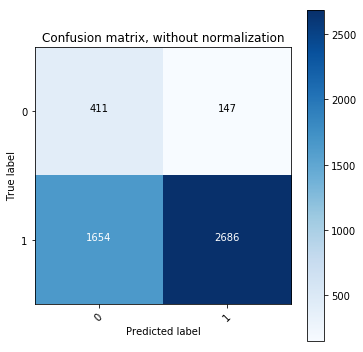

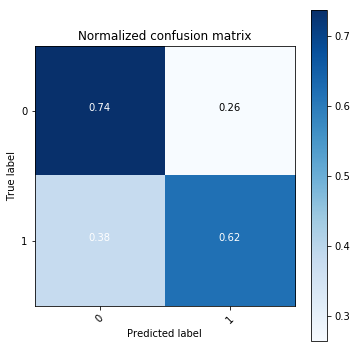

In [59]:
clf2 = linear_model.LogisticRegression(class_weight={0:0.93} )
#We have deleted Correlated Feature from the beggining that why we use l2 penality 
# --> Re use automatically detected correlation to impove the model
clf2.fit(X_train, y_train)
predictionsLREng = clf2.predict(X_testInit)
# Compute confusion matrix
class_names = [0,1]
cnf_matrix = confusion_matrix(y_testInit, predictionsLREng)
np.set_printoptions(precision=3)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

###### Voting Classifier

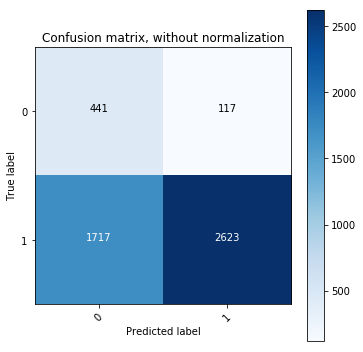

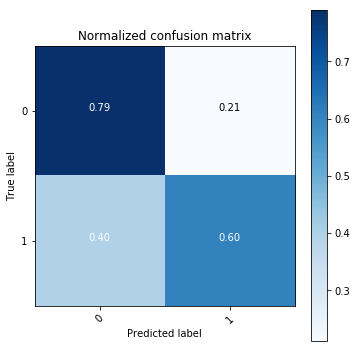

In [60]:
Ensembleclf = VotingClassifier(estimators=[('rf', clf1),('ada',adaClf),("logistic",clf2)],voting="hard")
Ensembleclf = Ensembleclf.fit(X_train, y_train)
predictionEnsemble = Ensembleclf.predict(X_testInit)
class_names = [0,1]
cnf_matrix = confusion_matrix(y_testInit, predictionEnsemble)
np.set_printoptions(precision=3)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()


###### ROC Curve

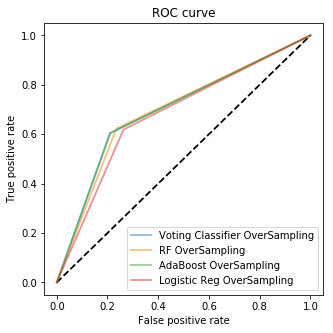

In [61]:
fpr_Ens, tpr_Ens, _ = roc_curve(y_testInit, predictionEnsemble)
fpr_RFEng, tpr_RFENG, _ = roc_curve(y_testInit, predictionEng)
fpr_AdaEng, tpr_AdaEng, _ = roc_curve(y_testInit, adapredictions)
fpr_LREng, tpr_LRENG, _ = roc_curve(y_testInit, predictionsLREng)

plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_Ens, tpr_Ens, label='Voting Classifier OverSampling',alpha=0.5)
plt.plot(fpr_RFEng, tpr_RFENG, label='RF OverSampling',alpha=0.5)
plt.plot(fpr_AdaEng, tpr_AdaEng, label='AdaBoost OverSampling',alpha=0.5)
plt.plot(fpr_LREng, tpr_LRENG, label='Logistic Reg OverSampling',alpha=0.5)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

###### Heart deases classification 

Avant d'entammer cette partie on a essayé de travailler avec des données temporelles issues de la ase de données sauf cela n'était pas possible vu le nombre très petit de ces derniers. On a donc orienté notre travail vers le développement de notre
business

1/ Buts :

Afin d'améliorer notre produit et nos services, on a amélioré notre application afin de collecter plus d'informations
sur les utilisateurs.

2/ Processus :

En réalité on a commencé à regarder les variations des états de santés de nos clients, et on a plannifié le développement de notre business
comme suit :

--> On s'est attaqué à l'axe des maladies cardiovasculaires dans un premier temps l'idée était de faire une analyse périodique 
afin de détecter des patternes annormaux de variations de la fréquence cardiaque, se cela est annormal nos spécialiste regardaient
ça et nous disaient s'il fallait qu'on demande au client des tests complémentaires ou pas afin d'éviter une maladie ou une
crise pouvant entraîner sa mort. 

Vu que les analyses complémentaires seront faîtes chez des laboratoires pour un premier temps on peut conclure des
accords avec certains, bien sur avec des tarifs préférenciels pour nos clients, une clientèle de plus pour ces derniers,
et une partie de l'argent sera pour nous.

    /!\ --> On compte après transformer notre produit en un KIT qui permet de faire quelques analyses chez-soi.


3/ Résultat : 

Deux BUTs qui ont été visés avec cette étape et qui sont déjà atteints :
	--> L'amélioration de la relation avec nos clients le gain de leurs confiances
	--> On a appris aux fur et à mesure de ce qu'on reçoive comme cas des situations et des diagnostiques qui nous permettent aujourd'hui de faire les analyses d'une façon automatique et donc on a réussi à laisser partir une grosse partie des médecins.

In [62]:
dfHeartBeat = pd.get_dummies(pd.read_csv("./Heart.csv").drop("Unnamed: 0",axis=1),columns=["ChestPain","Thal"])
dfHeartBeat.head()

,Age,Sex,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,AHD,ChestPain_asymptomatic,ChestPain_nonanginal,ChestPain_nontypical,ChestPain_typical,Thal_fixed,Thal_normal,Thal_reversable
0,63,1,145,233,1,2,150,0,2.3,3,0.0,No,0,0,0,1,1,0,0
1,67,1,160,286,0,2,108,1,1.5,2,3.0,Yes,1,0,0,0,0,1,0
2,67,1,120,229,0,2,129,1,2.6,2,2.0,Yes,1,0,0,0,0,0,1
3,37,1,130,250,0,0,187,0,3.5,3,0.0,No,0,1,0,0,0,1,0
4,41,0,130,204,0,2,172,0,1.4,1,0.0,No,0,0,1,0,0,1,0


In [63]:
dfHeartBeat["AHD"].replace(["No","Yes"],[0,1],inplace=True)
dfHeartBeat.head()

,Age,Sex,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,AHD,ChestPain_asymptomatic,ChestPain_nonanginal,ChestPain_nontypical,ChestPain_typical,Thal_fixed,Thal_normal,Thal_reversable
0,63,1,145,233,1,2,150,0,2.3,3,0.0,0,0,0,0,1,1,0,0
1,67,1,160,286,0,2,108,1,1.5,2,3.0,1,1,0,0,0,0,1,0
2,67,1,120,229,0,2,129,1,2.6,2,2.0,1,1,0,0,0,0,0,1
3,37,1,130,250,0,0,187,0,3.5,3,0.0,0,0,1,0,0,0,1,0
4,41,0,130,204,0,2,172,0,1.4,1,0.0,0,0,0,1,0,0,1,0


In [64]:
dfHeartBeat.info() #2 NaN we'll Delete Them

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 19 columns):
Age                       303 non-null int64
Sex                       303 non-null int64
RestBP                    303 non-null int64
Chol                      303 non-null int64
Fbs                       303 non-null int64
RestECG                   303 non-null int64
MaxHR                     303 non-null int64
ExAng                     303 non-null int64
Oldpeak                   303 non-null float64
Slope                     303 non-null int64
Ca                        299 non-null float64
AHD                       303 non-null int64
ChestPain_asymptomatic    303 non-null uint8
ChestPain_nonanginal      303 non-null uint8
ChestPain_nontypical      303 non-null uint8
ChestPain_typical         303 non-null uint8
Thal_fixed                303 non-null uint8
Thal_normal               303 non-null uint8
Thal_reversable           303 non-null uint8
dtypes: float64(2), int64(10), uint8

In [65]:
def discretise(age):
    if(age < 30):
        return 1
    else:
        if(age < 45):
            return 2
        else:
            if(age < 60):
                return 3
            else :
                if(age < 75):
                    return 4
                else:
                    return 5

In [66]:
dfHeartBeat = dfHeartBeat.dropna()
dfHeartBeat["Age"] = dfHeartBeat["Age"].apply(lambda x : discretise(x)) 

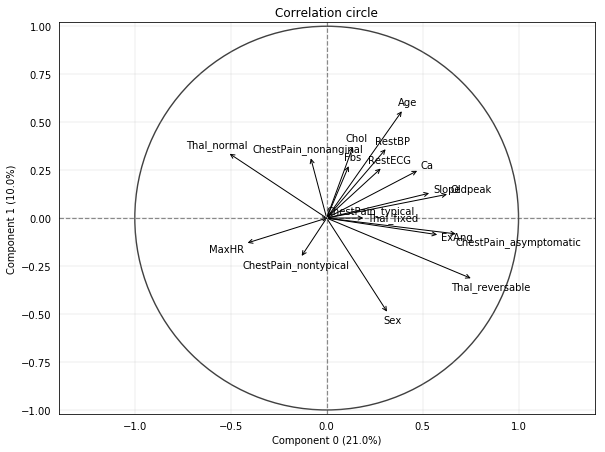

In [67]:
xCols = [elt for elt in dfHeartBeat.columns if elt != "AHD"]
XHeartBeat = dfHeartBeat[xCols].copy()
yHeartBeat = dfHeartBeat["AHD"].copy()
pca = prince.PCA(XHeartBeat, n_components=2)
pca.plot_correlation_circle()
plt.show()

On remarque que les gens souffrant des douleurs thoraciques ont un coeur qui bat a très haute fréquence.
On remarque aussi que le sexe n'influe pas sur l'apparition du thalassémie qui a une origine plutot hériditaire. En effet cette maladie est dû à un disfonctionnement de l'hémoglobine dont la géne responsable n'est pas XY ni XX.

On a un dataset propore on va passer la classification. On a souhaité de garder toutes les cariables et faire une classification directement dessus et nous éloigner des classifications sur els composantes qui générera plus de bruit et donc plus d'erreur de classification

###### Train test Split and Cross validation

In [68]:
X_trainHeart, X_testHeart, y_trainHeart, y_testHeart = train_test_split(XHeartBeat,yHeartBeat, test_size=0.33, random_state=69,stratify=yHeartBeat,shuffle=True)

###### Ada Boost Classifier

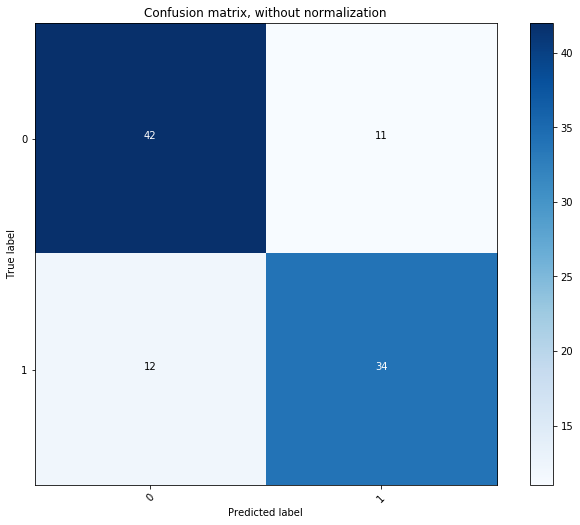

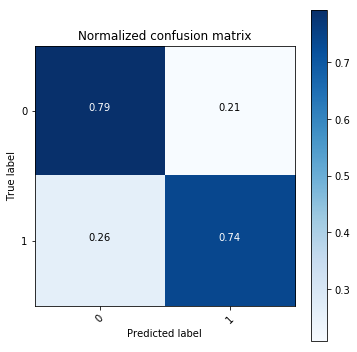

In [69]:
rng = np.random.RandomState(1)
adaClfHeart = AdaBoostClassifier(DecisionTreeClassifier(random_state=0),n_estimators=1000000, random_state=rng)
adaClfHeart.fit(X_trainHeart, y_trainHeart)
adapredictionsHeart = adaClfHeart.predict(X_testHeart)
cnf_matrix = confusion_matrix(y_testHeart, adapredictionsHeart)
np.set_printoptions(precision=3)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()


######  Random Forest Classifier

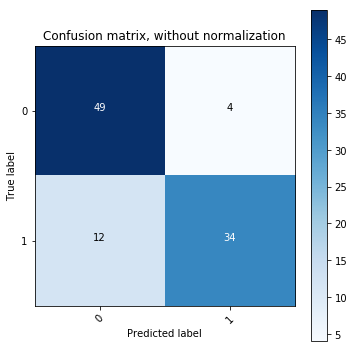

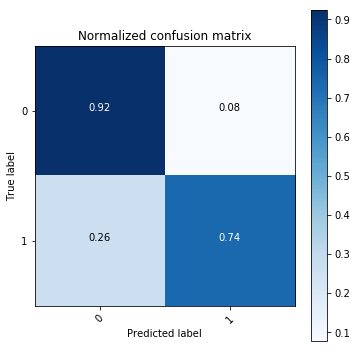

In [70]:
clf1Heart = RandomForestClassifier(max_depth=32,class_weight={1:0.8},random_state=0)
clf1Heart.fit(X_trainHeart, y_trainHeart)
predictionHeart= clf1Heart.predict(X_testHeart)
# Compute confusion matrix
class_names = [0,1]
cnf_matrix = confusion_matrix(y_testHeart, predictionHeart)
np.set_printoptions(precision=3)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()


###### Logistic Regression

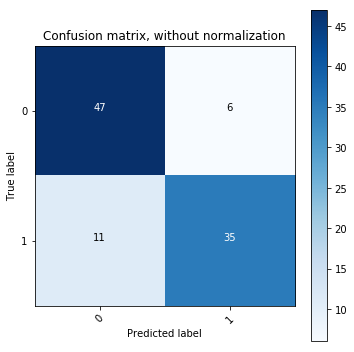

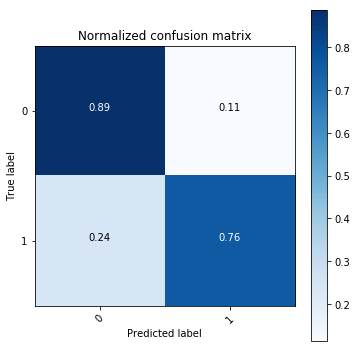

In [71]:
clf2Heart = linear_model.LogisticRegression()
#We have deleted Correlated Feature from the beggining that why we use l2 penality 
# --> Re use automatically detected correlation to impove the model
clf2Heart.fit(X_trainHeart, y_trainHeart)
predictionsLRHeart = clf2Heart.predict(X_testHeart)
# Compute confusion matrix
class_names = [0,1]
cnf_matrix = confusion_matrix(y_testHeart, predictionsLRHeart)
np.set_printoptions(precision=3)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

###### Voting Classifier

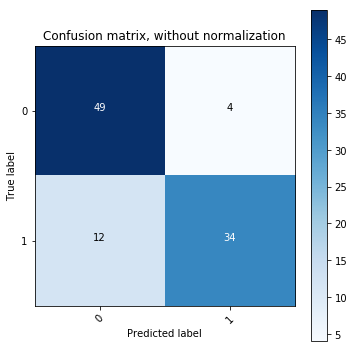

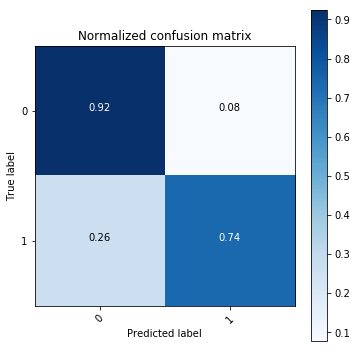

In [72]:
EnsembleclfHeart = VotingClassifier(estimators=[('lr', clf2Heart),('rf', clf1Heart),('ada',adaClfHeart)],voting="hard")
EnsembleclfHeart = EnsembleclfHeart.fit(X_trainHeart, y_trainHeart)
predictionEnsembleHeart = EnsembleclfHeart.predict(X_testHeart)
class_names = [0,1]
cnf_matrix = confusion_matrix(y_testHeart, predictionEnsembleHeart)
np.set_printoptions(precision=3)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()


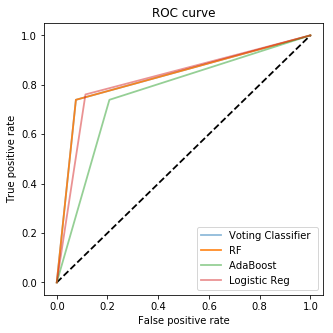

In [73]:
fpr_Ens, tpr_Ens, _ = roc_curve(y_testHeart, predictionEnsembleHeart)
fpr_RFEng, tpr_RFENG, _ = roc_curve(y_testHeart, predictionHeart)
fpr_AdaEng, tpr_AdaEng, _ = roc_curve(y_testHeart, adapredictionsHeart)
fpr_LREng, tpr_LRENG, _ = roc_curve(y_testHeart, predictionsLRHeart)

plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_Ens, tpr_Ens, label='Voting Classifier ',alpha=0.5)
plt.plot(fpr_RFEng, tpr_RFENG, label='RF ',alpha=0.9)
plt.plot(fpr_AdaEng, tpr_AdaEng, label='AdaBoost ',alpha=0.5)
plt.plot(fpr_LREng, tpr_LRENG, label='Logistic Reg ',alpha=0.5)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Random Forest est notre meilleur classifieur, en fait il maxisime l'air sous la courbe.
--> On ne prend pas trop de risque de nous tromper sur une analyse pour le moment.

Il faudra peut être avoir plus de cas pour améliorer nos classifications un peu plus.